#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

#### Extract data from XML Annotation

In [2]:
import xml.etree.ElementTree as xet
from glob import glob
import os

In [3]:
xml_path = os.path.join(os.getcwd(),'images','*xml')

In [4]:
path = glob(xml_path)

In [5]:
label_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])

In [6]:
for file in path:
    data = xet.parse(file)
    root = data.getroot()
    object = root.find('object')
    bnd_boxtag = object.find('bndbox')
    
    x_min = int(bnd_boxtag.find('xmin').text)
    x_max = int(bnd_boxtag.find('xmax').text)
    y_min = int(bnd_boxtag.find('ymin').text)
    y_max = int(bnd_boxtag.find('ymax').text)
    
    # Appending extracted coordinated into a dictionary
    
    label_dict['filepath'].append(file)
    label_dict['xmin'].append(x_min)
    label_dict['xmax'].append(x_max)
    label_dict['ymin'].append(y_min)
    label_dict['ymax'].append(y_max)
    

#### Convert Extracted XML data into a dataframe

In [7]:
df = pd.DataFrame(label_dict)
df.to_csv('labels.csv', index= False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,E:\PROJECT_NEURON\Automatic_Number_Plate_Recog...,1093,1396,645,727
1,E:\PROJECT_NEURON\Automatic_Number_Plate_Recog...,134,301,312,350
2,E:\PROJECT_NEURON\Automatic_Number_Plate_Recog...,31,139,128,161
3,E:\PROJECT_NEURON\Automatic_Number_Plate_Recog...,164,316,216,243
4,E:\PROJECT_NEURON\Automatic_Number_Plate_Recog...,813,1067,665,724


#### Extract respective image filename of XML and inserting it into a dataframe

In [8]:
filename = df['filepath'][0]

In [9]:
def get_filename(filename):
    image_filename = xet.parse(filename).getroot().find('filename').text
    image_filepath = os.path.join(os.getcwd(),'images',image_filename)
    return image_filepath

In [10]:
image_path = list(df['filepath'].apply(get_filename))

In [11]:
import plotly.express as px
from skimage import io
from IPython.display import Image

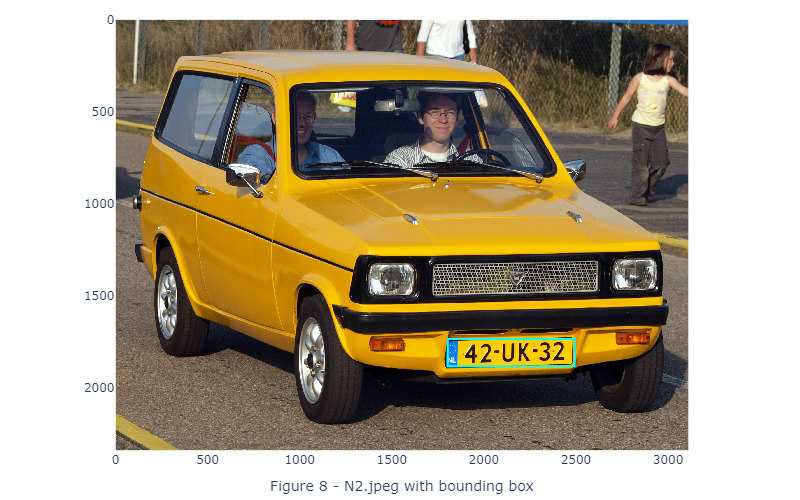

In [12]:
file_path = image_path[100] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=800, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 1 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')
image_filepath =os.path.join(os.getcwd(),'Test','test_image.png')
Image(filename=image_filepath) 

#### Data Preprocessing
- Each image we will convert into an array using OpenCV.
- We will resize image into (224,224) because it is the standard compatible size of pre trained transfer learning model ie. Inception Resnet v2.
- We will normalize the image by dividing with maximum number ie. 255( max no for 8 bit images) and the process is called normalization(Min-Max Scaler).
- We also need to normalize our labels too because for DL model output range should be between 0 to 1. For normalizing labels we need to divide the diagonal points with the width and height of image.

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [14]:
labels = df.iloc[:,1:].values
output= []
data = []

In [15]:
for index in range(len(image_path)):
    image = image_path[index]
    image_array = cv2.imread(image)
    height, width, depth = image_array.shape
    
    load_image = load_img(image, target_size=(224,224))
    load_image_array = img_to_array(load_image)
    
    # Normalize our image
    
    normalize_load_image_array = load_image_array/255.0
    
    # Normalize our labels
    
    xmin, xmax,ymin,ymax = labels[index]
    normalized_xmin, normalized_xmax = xmin/width, xmax/width
    normalized_ymin, normalized_ymax = ymin/height, ymax/height
    label_normalized = (normalized_xmin, normalized_xmax,normalized_ymin, normalized_ymax)
    
    # Appending Outputs and Data
    data.append(normalize_load_image_array)
    output.append(label_normalized)

#### Split Data into train and test set

In [16]:
X = np.array(data, dtype= np.float32)
y = np.array(output, dtype= np.float32)

In [17]:
# Splitting data into train and test split
x_train,x_test,y_train,y_test = train_test_split(X,y, train_size=0.8,random_state=0)
x_train.shape, x_test.shape, y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

#### Prepare Base Model 
- A pre-trained model has been previously trained on a dataset and contains the weights and biases that represent the features of whichever dataset it was trained on. 
- Inception-ResNet-v2 is a convolutional neural network that is trained on more than a million images from the ImageNet database

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input

In [19]:
inception_renet = InceptionResNetV2(weights='imagenet', include_top=False,input_tensor=Input(shape=(224,224,3)))
output_model = inception_renet.output
output_model = Flatten()(output_model)
output_model = Dense(500, activation = 'relu')(output_model)
output_model = Dense(250, activation = 'relu')(output_model)
output_model = Dense(4, activation ='sigmoid')(output_model)

In [20]:
model = Model(inputs = inception_renet.input, outputs= output_model)

In [21]:
# Compile our Model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])

In [22]:
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 64)  192         ['conv2d_11[0][0]']              
 ormalizat

 activation_21 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 25, 25, 48)   13824       ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 25, 25, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 48)  144         ['conv2d_22[0][0]']              
 ormalizat

                                                                                                  
 activation_24 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 25, 25, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_40 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 25, 25, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 25, 25, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 25, 25, 320)  0           ['block35_6[0][0]']              
          

 activation_58 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 25, 25, 32)   9216        ['activation_55[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 25, 25, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 25, 25, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 25, 25, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_69 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 25, 25, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_69[0][0]'] 
          

 activation_75 (Activation)     (None, 12, 12, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 12, 12, 1088  0           ['activation_72[0][0]',          
                                )                                 'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 12, 12, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 12, 12, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 12, 12, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 12, 12, 128)  384        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 12, 12, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 12, 12, 160)  143360      ['activation_93[0][0]']          
          

                                                                                                  
 batch_normalization_101 (Batch  (None, 12, 12, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_102 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 12, 12, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_109 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 12, 12, 160)  480        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_10

 conv2d_118 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 12, 12, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_116 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_118[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_127 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 12, 12, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_132 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 12, 12, 192)  576        ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 12, 12, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
          

 conv2d_143 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 12, 12, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 12, 12, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 12, 12, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_151 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 12, 12, 384)  0          ['activation_148[0][0]',         
          

 activation_156 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 12, 12, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 5, 5, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 5, 5, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_16

                                                                                                  
 activation_169 (Activation)    (None, 5, 5, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_167 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_170 (Conv2D)            (None, 5, 5, 256)    172032      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 5, 5, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_175 (Batch  (None, 5, 5, 192)   576         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 5, 5, 256)   768         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 5, 5, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 5, 5, 448)    0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 5, 5, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 5, 5, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 5, 5, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 5, 5, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 5, 5, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 5, 5, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 flatten (Flatten)              (None, 38400)        0           ['conv_7b_ac[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 500)          19200500    ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 250)          125250      ['dense[0][0]']                  
                                                                                                  
 dense_2 (

### Model Training

*Tensorboard*
- TensorBoard is a tool for providing the measurements and visualizations needed during the workflow.
- It enables tracking experiment metrics like loss and accuracy

*Batch Size*
- The batch size defines the number of samples that will be propagated through the network.

- let's say you have 1000 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. 


In [23]:
tensorboard = TensorBoard('object detection')
history = model.fit(x=x_train, y= y_train,batch_size=8, epochs=1, validation_data=(x_test,y_test),callbacks=[tensorboard])

23/23 [==============================] - 37s 636ms/step - loss: 0.0334 - accuracy: 0.5889 - val_loss: 0.0335 - val_accuracy: 0.0667


#### Saving our trained model

In [24]:
model.save('anpr_model.h5')

#### Make Predictions

In [25]:
model = tf.keras.models.load_model('anpr_model.h5')

In [26]:
def object_detection(path, filename,model):
    # Read image
    image = load_img(path)  # PIL object
    image = np.array(image, dtype=np.uint8)  # 8 bit array (0,255)
    image1 = load_img(path, target_size=(224, 224))
    # Data preprocessing
    # Convert into array and get the normalized output
    image_arr_224 = img_to_array(image1)/255.0
    h, w, d = image.shape
    #### In order to pass this image to our model, we need to provide the data in the dynamic fourth dimension.
    #### 1 indicates the number of image, As here we are passing only one image
    test_arr = image_arr_224.reshape(1, 224, 224, 3)
    # Make predictions
    coords = model.predict(test_arr)
    # Denormalize the values
    denorm = np.array([w, w, h, h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    # Draw bounding on top the image
    xmin, xmax, ymin, ymax = coords[0]
    pt1 = (xmin, ymin)
    pt2 = (xmax, ymax)
    print(pt1, pt2)
    cv2.rectangle(image, pt1, pt2, (0, 255, 0), 5)
    # Convert into bgr
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    prediction_img_path = os.path.join(os.getcwd(),'predictions')
    os.makedirs(prediction_img_path, exist_ok=True)
    prediction_img_path = os.path.join(os.getcwd(),'predictions',filename)
    cv2.imwrite(prediction_img_path, image_bgr)
    return coords

##### cv2.rectangle
- Syntax - cv2.rectangle(image, starting_point, end_point, Color, thickness)

##### cv2.cvtColor
- It is used to convert an image from one color space to another
- Sytnax = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

##### cv2.imwrite
- It is used to save an image to our storage device and this saves an image according to a specific format.
- Syntax = cv2.imwrite(path, image_bgr)

In [27]:
path = './Test/car_image.jpeg'
cordinates = object_detection(path,'car_image.jpeg',model)

1/1 [==============================] - 4s 4s/step
(535, 527) (772, 599)
